In [46]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import table
import os, sys, json
from pulp import *

%matplotlib inline

# Penjadwalan Perawat 

## Implementasi algoritma Linear Programming untuk penyelasaian masalah penjadwalan Perawat. 


### asumsi dan batasan (konstrain):

* Setiap hari dibagi menjadi 2 shift, yakni shift siang dan malam, dengan masing-masing shift masing-masing 12 jam


* Terpenuhi kebutuhan jumlah perawat untuk tiap shift 

* Jika ada permintaan cuti untuk hari tertentu maka perawat tidak boleh dijadwalkan dalam shift dihari cuti. 

* Periode penjadwalan selama 4 minggu (28 hari). 
    
* Dalam tugas ini, yang digunakan 1 minggu untuk kemudahan visualisasi.

* Setiap perawat bekerja dalam 12, 24 atau 36 jam dalam seminggu.


### Setiap perawat:

* Tidak ada perawat yang akan bekerja pada kedua shift dalam satu hari.

* Seorang perawat yang bekerja pada shift malam akan mengambil cuti pada hari berikutnya.

* Jumlah shift malam maksimal untuk setiap perawat paling banyak SATU.

## Model:

* ide pentingnya adalah memperkenalkan variabel biner ***x_ns*** untuk linierisasi model


* Batasan dan fungsi tujuan dapat direpresentasikan sebagai persamaan persamaan dan pertidaksamaan.

\begin{align}
    x_{ns}= 
        \begin{cases}
            0, &\text{perawat n tidak akan bekerja pada shift s}\ \\
            1, &\text{perawat n akan bekerja pada shift s}\
        \end{cases}
\end{align}

* s: indeks shift

* n: indeks perawat

* r: daftar kebutuhan perawat tiap hari.


\begin{align}
    \text{r} = [\text{jumlah perawat yang dibutuhkan dalam shift tertentu}] \\
    \text{r[index genap]} = [\text{jumlah perawat yang dibutuhkan dalam shift harian}] \\
    \text{r[index ganjil]} = [\text{jumlah perawat yang dibutuhkan pada shift malam}] 
\end{align}

* PTO = Menyimpan informasi shift di luar kerja (perawat meminta PTO (Cuti) atau alasan lain)

\begin{align}
    \text{PTO} = \{n : [\text{daftar shift luar kerja perawat n}]\}
\end{align}


* shift_harian: [0, 1] in this case(siang = 0 /malam = 1).

* shift_kerja = [1,2,3]: perawat bekerja 12, 24, 36 jam per minggu.

* periode_penjadwalan: in this notebook, periode_penjadwalan = 1. 

* fungsi obyektif: meminimalkan jumlah perawat terjadwal dengan memenuhi semua batasan.

* Nantinya, preferensi shift/perawat tertentu dan batasan lainnya dapat disesuaikan. 

* Implementasi algoritma linear programming dengan pulp/python untuk menyelesaikan penjadwalan perawat

## Inisialisasi Parameter

In [47]:
# jumlah jam kerja perawat 12, 24, 36 jam perminggu.
working_shift = [1, 2, 3] 

# jumlah maksimum shift setiap minggu untuk tiap perawat
max_shifts = 3

# planning_length
planning_length = 1 

# Jumlah shift tiap hari:
daily_shift = [0, 1]

# Label hari kalender dari senin sampai dengan sabtu. 
d = ['Senin', 'Selasa', 'Rabu', 'Kamis', 'Jumat','Sabtu','Minggu']

# Membuat dataframe  require_nurses (kebutuhan perawat) 
# day_nurse: Jumlah kebutuhan perawat tiap hari untuk setiap shift siang.
# night_nurse: Jumlah kebutuha  perawat tiap hari untuk setiap shift malam.
col = range(0, 7*planning_length)

require_nurses = pd.DataFrame(data = None, columns=d, index = daily_shift)
for j in col:
    # Angka nilai yang kecil digunakan untuk memudahkan visualisasi.
    day_nurse, night_nurse = 5, 3
    require_nurses.iat[0, j] = day_nurse
    require_nurses.iat[1, j] = night_nurse


# Jumlah perawat yang dibutuhkan untuk tiap shift

# r[even index]: jumlah perawat yang dibutuhkan tiap hari untuk shif siang
# r[odd index]: jumlah perawat yang dibutuhkan tiap hari untk shift malam

print (require_nurses)

r = require_nurses.values.swapaxes(0,1).ravel()

print ("Jumlah perawat yang dibutuhkan setiap shift:") 
print (r)

print ("\nDalam format matrix:")
print (require_nurses.head())


# Total Jumlah Perawat
total = int(sum(r)/2.5)
print ("\nTotal jumlah perawat adalah: {}".format(total))

# Membuat id perawat
nurses_id = ['perawat '+str(i) for i in range(total)]
print ("\nID perawat: ")
print (nurses_id)

  Senin Selasa Rabu Kamis Jumat Sabtu Minggu
0     5      5    5     5     5     5      5
1     3      3    3     3     3     3      3
Jumlah perawat yang dibutuhkan setiap shift:
[5 3 5 3 5 3 5 3 5 3 5 3 5 3]

Dalam format matrix:
  Senin Selasa Rabu Kamis Jumat Sabtu Minggu
0     5      5    5     5     5     5      5
1     3      3    3     3     3     3      3

Total jumlah perawat adalah: 22

ID perawat: 
['perawat 0', 'perawat 1', 'perawat 2', 'perawat 3', 'perawat 4', 'perawat 5', 'perawat 6', 'perawat 7', 'perawat 8', 'perawat 9', 'perawat 10', 'perawat 11', 'perawat 12', 'perawat 13', 'perawat 14', 'perawat 15', 'perawat 16', 'perawat 17', 'perawat 18', 'perawat 19', 'perawat 20', 'perawat 21']


## Perawat libur pada spesifik shift tertentu

In [48]:
#  

with open('utils/off_shift.json', 'r') as fp:
    off_shift = json.load(fp)
    
print (off_shift)

{'0': [1], '2': [0], '3': [12, 10], '4': [7, 13], '5': [1], '10': [3], '15': [2]}


## Shifts dan daftar Perawat

In [49]:
'''
shifts: label tiap shift. Sabagai contoh : Hari senin shift siang adalah 0, Hari senin shift malam adalah 1, Selasa shift pagi adalah 2, dst.
perawat: label untuk tiap perawat. untuk tujuan penyederhanaan digunakan id integer.
'''

shifts = range(2*7*planning_length)
nurses = range(total)

#print ("The shifts are: ")
#print (shifts)
#print (nurses)

#print (d)
#print (s)
## Membuat nama shift berdasarkan indeks:
shift_name = []
for s in shifts:
    # Temukan shift siang atau malam di setiap hari
    #print(s)
    if (s%2):
        n_or_day = 'm'
    else:
        n_or_day = 's'
    shift_name.append(d[int(s/2)] + '_' + n_or_day)
print ("Nama Shift adalah: ")
print (shifts)

print ("\nThe names of corresponding shifts are: ")
print (shift_name)

print ("\nData Perawat adalah: ")
print (nurses)

Nama Shift adalah: 
range(0, 14)

The names of corresponding shifts are: 
['Senin_s', 'Senin_m', 'Selasa_s', 'Selasa_m', 'Rabu_s', 'Rabu_m', 'Kamis_s', 'Kamis_m', 'Jumat_s', 'Jumat_m', 'Sabtu_s', 'Sabtu_m', 'Minggu_s', 'Minggu_m']

Data Perawat adalah: 
range(0, 22)


## Build constraint models:

* var = pulp.LpVariable(name, lowbound, upbound, cat="Binary")

* pb = pulp.LpProblem(name_str, sense = 'LpMaximize' or LpMinimize)


* problem.solve(pulp.solvers.GLPK(msg=0))

* check status: pulp.LpStatus(pb.status)

* pulp.value(pb.objective)

* Optimal solution: var.varValue

In [50]:
def LpProb():

    '''

    '''

    # The prob variable is created to contain the problem data   
    prob = LpProblem("Penjadwalan Perawat",LpMinimize)
    
    # Membuat variabel keputusan. 
    var = {
     (n, s): pulp.LpVariable(
        "schdule_{0}_{1}".format(n, s), cat = "Binary")
        for n in nurses for s in shifts
    }

    
    # Menambahkan Konstrain: 
    # Perawat tidak diijikan shift yang sama secara berurutan
    # Jika perawat ambil shift malam, besoknya diberikan libur 

    for n in nurses:
        for s in shifts:
            if s%2 == 0:
                prob.addConstraint(
                var[(n,s)] + var[(n, s+1)] <= 1  # untuk shift siang
               )
            elif s%2 == 1 and s < shifts[-1]:
                # night shift. Do not forget to add condition that the last
                # shift in the scheduling does not count.
                prob.addConstraint(
                var[(n, s)] + var[(n, s+1)]+var[(n, s+2)] <= 1
                )

    # menambahkan konstrain:
    for n in nurses:
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                prob.addConstraint(
                var[(n, s)] == 0
                )

    # menambahkan konstrain:
    for n in nurses:
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) <= 3    
        )
        prob.addConstraint(
        sum(var[(n,s)] for s in shifts) >= 1
        )

    # menambahkan konstrain
    # Maksimum jumlah shift malam untuk tiap perawat dalam 1 minggu

    for n in nurses:
        prob.addConstraint(
        sum(var[(n, s)] for s in shifts if s%2) <= 1
        )
    # menambahkan konstrains
    # untuk tiap shift jumlah perawat yang berdinas harus lebih besar dari jumlah kebutuhan perawat tiap shift
    for s in shifts:
        try:
            prob.addConstraint(
            sum(var[(n,s)] for n in nurses) >= r[s]
            )
        except:
            print ("len(shifts) should be equal to len(require_nurses)")
            sys.exit(-1)   

            
    # fungsi obyektif: meminimalkan jumlah kebutuhan perawat
    # nurse_working = []
    # for s in shifts:
    #     nurse_shift = sum(var[(n, s)] for n in nurses)
    #     nurse_working.append(
    #     pulp.LpVariable("nurses_%d"%(s,), cat = 'Integer', lowBound = 0)
    #     )
    prob.objective = sum(var[(n,s)] for n in nurses for s in shifts)    
    
    return var, prob

In [51]:
## Run the solver

var, prob = LpProb()
prob.solve()
#print (LpStatus[prob.status])

#for name, c in list(prob.constraints.items()):
#    print(name, ":", c, "\t", c.pi, "\t\t", c.slack)

C:\Python312\Lib\site-packages\pulp\pulp.py:1298: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


1

## Check Constraints

In [52]:
def check_off_shift():
    # nilai True jika kontrain terpenuhi dan false jika kontrain dilanggar

    for n in nurses:
        if str(n) in off_shift:
            for s in off_shift[str(n)]:
                if value(var[(n,s)]) == 1:
                    print (n, s)
                    return False

    for n in nurses:
        for s in shifts:
            if s%2 == 0:
                if value(var[(n,s)]) + value(var[(n, s+1)]) > 1:
                    return False  # for day shift
            elif s%2 == 1 and s < shifts[-1]:
                if value(var[(n,s)]) + value(var[(n,s+1)]) + value(var[(n, s+2)]) > 1:
                    return False

    for n in nurses:
        tmp = sum(value(var[(n,s)]) for s in shifts) 
        if tmp > 3 or tmp < 1:
            return False

    for n in nurses:
        if sum(value(var[(n, s)]) for s in shifts if s%2) > 1:
            return False

    for s in shifts:
        try:
            if sum(value(var[(n,s)]) for n in nurses) < r[s]:
                return False
        except:
            print ("len(shifts) should be equal to len(require_nurses)")
            sys.exit(-1)   

    return True



print ("Check the off_shift constraint: {}".format(check_off_shift()))

Check the off_shift constraint: True


## Find the schedule for all nurses

In [53]:
def nurse_scheduling(var = var):

    schedule = pd.DataFrame(data=None, index = nurses_id, columns = shift_name)
    
    for k, v in var.items():
        n, s = k[0], k[1]
        schedule.iat[n, s] = int(value(v))
        
    return schedule

In [54]:
schedule = nurse_scheduling()

schedule.head(5)

,Senin_s,Senin_m,Selasa_s,Selasa_m,Rabu_s,Rabu_m,Kamis_s,Kamis_m,Jumat_s,Jumat_m,Sabtu_s,Sabtu_m,Minggu_s,Minggu_m
perawat 0,1,0,1,0,0,0,0,0,0,1,0,0,0,0
perawat 1,0,1,0,0,0,0,1,0,1,0,0,0,0,0
perawat 2,0,1,0,0,1,0,1,0,0,0,0,0,0,0
perawat 3,0,0,1,0,0,0,0,0,0,0,0,0,0,1
perawat 4,0,0,0,0,0,0,1,0,1,0,0,0,1,0


## Find out the schedule for each nurse

In [39]:
# Input the nurse id

def schedule_which_nurse(nurseWho, table = var):
    
    '''
    nurse Who: nurse id
    table: Either the schedule dataframe or the linear programming solution
    inputType: if 'lp': use linear programming solution
               else: the dataframe
    '''
    # Get the data for scheduling nurse n:
    sch = []
       
    for s in shifts:
        sch.append(
            int(value(table[(nurseWho, s)]))
            )
    
    sch = np.array(sch).reshape(int(len(sch)/2), 2).swapaxes(0, 1)
    
    df_sch = pd.DataFrame(sch, index = ['siang', 'malam'], columns = d)
    
    return df_sch
    

In [40]:
#nurse0 = schedule_which_nurse(0)

#print ("The schedule for the nurse0 is:")

#nurse0

## Visualize the schedule

In [41]:
def plot_table(df, figSize = (4,2), saveFig = False, figTitle = 'nurse_scheduling'):
    colors = df.map(lambda x: 'lightgray' if x== 0 else 'lightcoral') 
    fig = plt.figure(figsize=figSize)
    ax = plt.subplot(2, 1, 1, frame_on = True)  # no visible frame
    ax.axis('off')
    # Menentukan warna 
    tb1 = pd.plotting.table(ax,df,
                loc='center',
                cellLoc='center',
                cellColours=colors.values,
                fontsize=14
          )

    if saveFig == True:
        if not os.path.isdir('figs/notebook/'):
            os.mkdir('figs/notebook/')
        plt.savefig('figs/notebook/'+ figTitle +'.png', bbox_inches='tight', dpi = 150)
    # refresh the plot
    plt.show()

Jadwal dinas untuk semua perawat: 


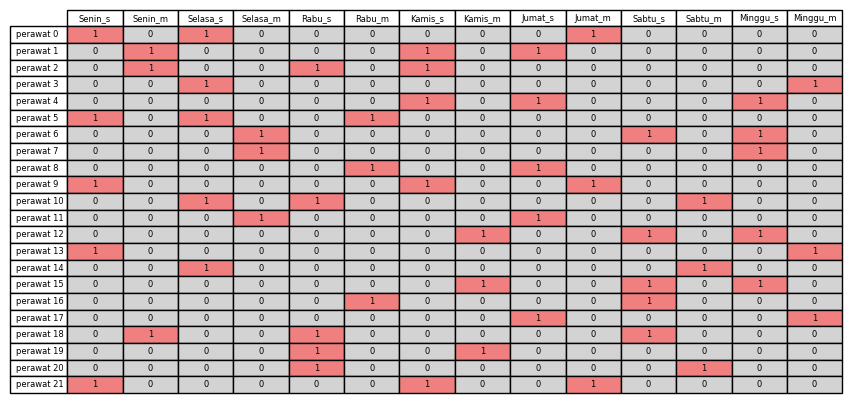

Perawat yang dibutuhkan adalah: 
[5 3 5 3 5 3 5 3 5 3 5 3 5 3]


In [42]:
print ("Jadwal dinas untuk semua perawat: ")
plot_table(schedule, figSize = (10, 4), saveFig = True)

print ("Perawat yang dibutuhkan adalah: ")
print (r)

Jadwal dinas untuk perawat0


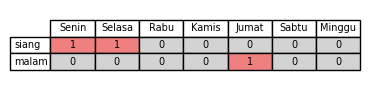

Jadwal dinas untuk perawat1


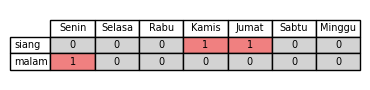

Jadwal dinas untuk perawat2


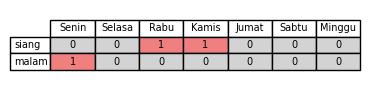

Jadwal dinas untuk perawat3


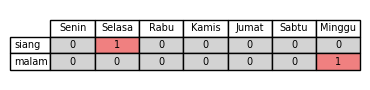

Jadwal dinas untuk perawat4


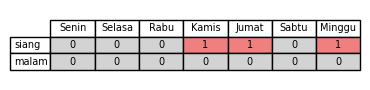

Jadwal dinas untuk perawat5


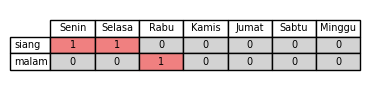

Jadwal dinas untuk perawat6


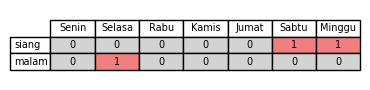

Jadwal dinas untuk perawat7


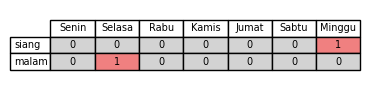

Jadwal dinas untuk perawat8


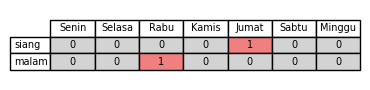

Jadwal dinas untuk perawat9


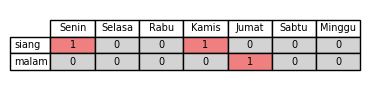

In [43]:
for n in nurses[:10]:
    print ('Jadwal dinas untuk perawat' + str(n))
    n0 = schedule_which_nurse(n)
    plot_table(n0, saveFig = True, figTitle = 'Perawat ' + str(n))

Jadwal dinas untuk perawat11


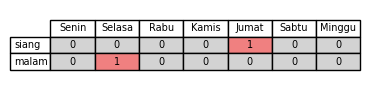

Jadwal dinas untuk perawat12


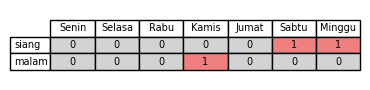

Jadwal dinas untuk perawat13


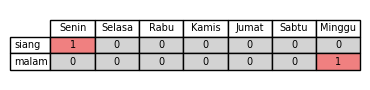

Jadwal dinas untuk perawat14


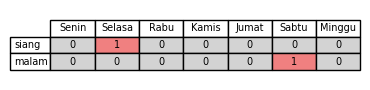

Jadwal dinas untuk perawat15


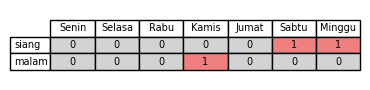

Jadwal dinas untuk perawat16


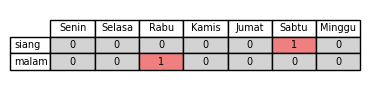

Jadwal dinas untuk perawat17


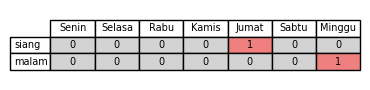

Jadwal dinas untuk perawat18


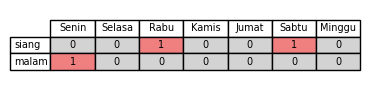

Jadwal dinas untuk perawat19


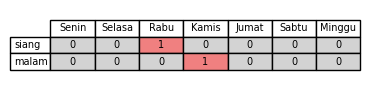

In [55]:
for n in nurses[11:20]:
    print ('Jadwal dinas untuk perawat' + str(n))
    n0 = schedule_which_nurse(n)
    plot_table(n0, saveFig = True, figTitle = 'perawat' + str(n))